In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [ ]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [ ]:
vaccinations = vaccinations.fillna(value=0)
cases = cases.fillna(value=0)

In [ ]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [ ]:
counties['FIPS'] = 1000*counties['STATE']+counties['COUNTY']

In [ ]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [ ]:
county_data = counties.join(cases.set_index("FIPS"), on = 'FIPS', how = 'inner').join(mask_use.set_index('COUNTYFP'), on = 'FIPS', how = 'inner')
county_data["COUNTYFP"] = county_data["FIPS"]
county_data

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/9/21,9/10/21,9/11/21,9/12/21,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,COUNTYFP
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9145,9207,9246,9287,0.053,0.074,0.134,0.295,0.444,1001
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34536,34726,34872,34950,0.083,0.059,0.098,0.323,0.436,1003
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3243,3260,3282,3295,0.067,0.121,0.120,0.201,0.491,1005
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3727,3752,3778,3795,0.020,0.034,0.096,0.278,0.572,1007
5,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9048,9095,9161,9176,0.053,0.114,0.180,0.194,0.459,1009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,6034,6111,6111,6111,0.061,0.295,0.230,0.146,0.268,56037
3190,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,4587,4611,4611,4611,0.095,0.157,0.160,0.247,0.340,56039
3191,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,3168,3204,3204,3204,0.098,0.278,0.154,0.207,0.264,56041
3192,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,1111,1120,1120,1120,0.204,0.155,0.069,0.285,0.287,56043


In [ ]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

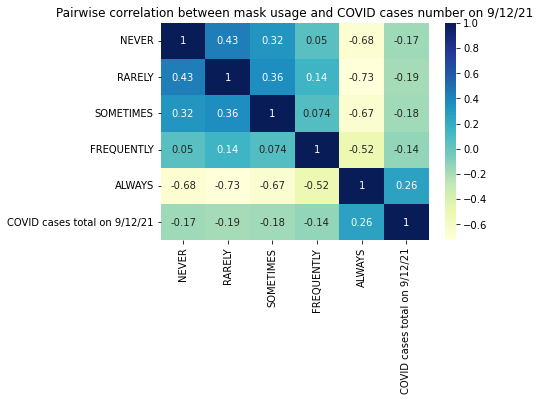

In [ ]:
county_small = county_data.loc[:, ("COUNTYFP","9/12/21")]
temp = mask_use.merge(county_small, on = "COUNTYFP", how = "left").drop(columns="COUNTYFP").rename(columns={"9/12/21": "COVID cases total on 9/12/21"})
dataplot = sns.heatmap(temp.corr(), cmap="YlGnBu", annot=True)
plt.title("Pairwise correlation between mask usage and COVID cases number on 9/12/21");

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [ ]:
X_q5b = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_q5b = county_data['9/12/21']

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_test = X_q5b.sample(frac=0.33,random_state=42)
X_q5b_train = X_q5b.drop(X_q5b_test.index)
y_q5b_test = y_q5b.sample(frac=0.33,random_state=42)
y_q5b_train = y_q5b.drop(y_q5b_test.index)

from sklearn import linear_model as lm

linear_model_m1 = lm.LinearRegression(fit_intercept=True)

y_fitted_5b = linear_model_m1.fit(X_q5b_train, y_q5b_train).predict(X_q5b_train)
y_predicted_5b = linear_model_m1.fit(X_q5b_train,
y_q5b_train).predict(X_q5b_test)

def rmse(predicted, actual):
     return np.sqrt(np.mean((actual - predicted)**2))

train_rmse_cases = rmse(y_fitted_5b, y_q5b_train)
test_rmse_cases = rmse(y_predicted_5b, y_q5b_test)

train_rmse_cases, test_rmse_cases

(27834.430707426982, 62591.13087482178)

In [ ]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

_One potential reason the test set RMSE is much higher as compared to the training set RMSE is that overfitting is happening. Another reason is that the direct correlation between the number of cases and make use is not very strong, so we may want to take other factors, for instance the population of each county, into account._

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [ ]:
X_q5d = county_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y_q5d = county_data['9/12/21']/county_data['POPESTIMATE2020']

X_q5d_test = X_q5d.sample(frac=0.33,random_state=42)
X_q5d_train = X_q5d.drop(X_q5b_test.index)
y_q5d_test = y_q5d.sample(frac=0.33,random_state=42)
y_q5d_train = y_q5d.drop(y_q5b_test.index)

from sklearn import linear_model as lm

linear_model_m2 = lm.LinearRegression(fit_intercept=True)

y_fitted_5d = linear_model_m2.fit(X_q5d_train, y_q5d_train).predict(X_q5d_train)
y_predicted_5d = linear_model_m2.fit(X_q5d_train,y_q5d_train).predict(X_q5d_test)

train_rmse_cpc = rmse(y_fitted_5d, y_q5d_train)
test_rmse_cpc = rmse(y_predicted_5d, y_q5d_test)

train_rmse_cpc, test_rmse_cpc

(0.03540985737823185, 0.038167903498916037)

In [ ]:
grader.check("q5d")

q5d results: All test cases passed!

_The RMSE's are very close to each other. This makes sense, as taking the per capita decreases the y-values and results in errors that are scaled down The differences between training and test RMSE are also much closer, which again makes sense, as it should be easier to predict cases per capita than just cases, since we are not including population as a feature, despite it being a major factor._

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

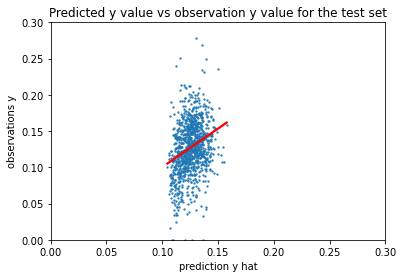

In [18]:
ax=sns.regplot(x= y_predicted_5d,y = y_q5d_test, scatter_kws={"s":2}, ci = None, line_kws={"color": "red"});
plt.ylim(0, 0.3);
plt.xlim(0, 0.3);
plt.title("Predicted y value vs observation y value for the test set");
plt.xlabel("prediction y hat");
plt.ylabel("observations y");


#Most outliers have high y-values, indicating that the model's prediction is less significantly less
#than actual observations. This also decreases the slope for the regression line, making it flatter.

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [19]:
import random

models = []

for i in range(1000):
    random_rows = []
    for row in range(len(X_q5d_train)):
        random_rows.append(random.randint(0, len(X_q5d_train)-1))
    X_train = X_q5d_train.iloc[random_rows]
    Y_train = y_q5d_train.iloc[random_rows]
    models.append(LinearRegression().fit(X_train, Y_train))

In [20]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [21]:
prop_var = np.array([model.predict(X_q5d_test.iloc[[100]])[0] for model in models])

numerator = np.mean((prop_var-np.mean(prop_var))**2)
denominator = np.mean((y_q5d_test.iloc[100]-prop_var)**2)
prop_var=numerator/denominator
prop_var

0.001349362344231594

In [22]:
grader.check("q5g")

q5g results: All test cases passed!

In [34]:
numerator

2.122322240924646e-06

In [35]:
denominator

0.0017055090694895463

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

_The extremely small variance-bias ratio indicates that there is much more bias than variance, and so we have low model complexity and should introduce more features. Model variance is at the $10^{-6}$ magnitude, whereas model bias is at the $10^{-3}$ magnitude (which we can see from the previous part), which leaves model risk at $10^{-3}$ order of magnitude. This means that bias is a whole three orders of magnitude larger than bias, and so variance has a relatively small contribution to the error. We should focus on reducing bias instead._

_However, as the article explains, there is possibly a great deal of incorrect information involved as counties report cases as they are tested. The number of positive tests is not necessarily equal to the true number of cases, and according to the article, can be predicted to be off by a magnitude of 2 to 100 in the United States. This magnitude dwarfs our model variance and model bias. Whereas the assumption of $\epsilon=0$ gave the impression that bias was the largest contributor to risk, this information that the biggest contributor to model risk is actually observational noise._

_One way to try to approximate observational noise is to measure the number of new cases confirmed in a county, then check the number of reported cases over the next week. As COVID-19 has an incubation period of approximately a week, anyone displaying COVID symptoms over the course of the next week should have been caught by the tests. This can be used to get an estimate for the true number of cases a week before, and by comparing this estimate to the number of confirmed cases, we can get an approximation for the magnitude of observational error. By taking multiple such approximations, we can come to model $\epsilon$. Of course, we also have to account for roughly 30% of people being asymptotic. The problem with the assumption that $\epsilon=N(\mu,\sigma)$ is that we don't actually know that $\epsilon$ can be modelled as a normal function. On the contrary, the article suggests that our observed data may be a fraction of the true number of cases. Additionally, since the true number of cases will almost always be greater than the number of confirmed cases, $g(x)>Y(x)$, so our $\epsilon$ will have an average of less than 0 anyways. Instead, a more accurate representation might be $y=g(x)+N(\mu,\sigma)x$, where $\mu<0$, so that the model can account for error being a function of $x$._

_The standard bias-variance decomposition probably does not fit well, as we are aware that the observational variance is likely off by a factor of the number of cases, which is not well-modeled by a normal distribution. 5e demonstrates that the plot of predicted y versus actual y is a downward parabola, implying that if we wish to keep $\epsilon$ as a normal distribution centered at 0, it may work better to use some kind of additional noise variable of $-\epsilon^3$. Otherwise, the error may have to be a function of $x$._

_For the model bias to be 0, the model must perfectly predict number of cases. This is possible by accident, but not possible in practice. The fact that observational variance will be nonzero makes it likely that our model will consistently off, and even if we perfected it so that $\hat{Y}=Y$, that is, so that our model perfectly predicts the number of confirmed cases, the prediction would still not match the number of true cases, $g(x)$._

_If we get infinite samples, we could theoretically test everyone. In which case we could have no observational bias; observational bias would be 0. As a result, yes, we would be able to reduce bias to 0, as $E(Y)=g$, and we can get $\hat{Y}=Y$ since we have infinite samples and can just sample the whole population._

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [25]:
avg_var, avg_mse = [], []
predictions = pd.DataFrame()
count = 0
for model in models:
    predictions[count] = model.predict(X_q5d_test)
    count += 1
for i in range(len(X_q5d_test)):
    avg_var.append(np.var(predictions.iloc[i]))
    avg_mse.append(np.mean((y_q5d_test.iloc[i]-predictions.iloc[i])**2))

avg_var, avg_mse=np.mean(avg_var),np.mean(avg_mse)
avg_var, avg_mse

(3.9531682931346424e-06, 0.0014606188771244476)

In [26]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

_We can try changing the model to reduce mean square error. As it is, we are using linear regression, trying to model $g(x)$ as $\hat{y}=ax+b$. However, as 5e showed, a better model might be a polynomial regression of degree 3, as the plot of $\hat{y}$ versus $y$ appeared like a downward parabola. Variance is approximately 0.000002 and bias is 0.0017, while the average values are approximately 0.000004 and 0.0015, respectively._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

In [ ]:
#Vaccination data is from https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh/data
#importing vaccination data
county_vaccinations = pd.read_csv('https://data.cdc.gov/api/views/8xkx-amqh/rows.csv')
county_vaccinations = county_vaccinations[county_vaccinations['Date']=='09/12/2021'][['FIPS', 'Series_Complete_Pop_Pct']]

#cleaning vaccination data
county_vaccinations = county_vaccinations.rename(columns={'Series_Complete_Pop_Pct': "percentage_vaccinated"})
county_vaccinations = county_vaccinations[county_vaccinations['FIPS'].apply(lambda x: str(x).isdigit())]
county_vaccinations['FIPS'] = county_vaccinations['FIPS'].astype(int)
county_copy = county_data.merge(county_vaccinations, how = "left", left_on= 'FIPS', right_on = 'FIPS')
county_copy = county_copy.dropna()

#Import data and initial cleaning:
apple_mobility = pd.read_csv("https://covid19-static.cdn-apple.com/covid19-mobility-data/2203HotfixDev14/v3/en-us/applemobilitytrends-2021-12-07.csv")
apple_mobility = apple_mobility[apple_mobility["country"] == "United States"]
apple_mobility = apple_mobility.iloc[:,:apple_mobility.columns.get_loc("2021-09-13")]
apple_mobility = apple_mobility[apple_mobility["geo_type"] == "county"].drop(['geo_type', 'country'],axis=1) 
apple_mobility = apple_mobility.groupby(["region", "sub-region"]).agg("sum").reset_index()
apple_mobility

In [ ]:
#Clean the table so that it only have date up to 09/12/2021, which matches the county_data，
#then we groupby county and take the sum for each for late modeling

# getting the average mobility, has to be done before merge
apple_mobility['avg_mobility'] = apple_mobility.iloc[:,apple_mobility.columns.get_loc('2020-01-13'):apple_mobility.columns.get_loc('2021-09-12')].mean(axis=1)
apple_mobility

In [ ]:
county_copy = county_copy.merge(apple_mobility, how = "left", left_on= ["CTYNAME", "STNAME"], right_on = ["region", "sub-region"])


death = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
death = death.iloc[:,:death.columns.get_loc("9/13/21")].groupby("FIPS").agg("sum").reset_index()
death = death.iloc[:3141,:]
death["FIPS"] = death["FIPS"].astype(int)
death = death.drop(['UID', 'code3', "Lat", "Long_"],axis=1)
death_fips= death["FIPS"].values
death_pop = death["Population"].values
death =death.iloc[:,2:].div(death.Population, axis=0)
death = death.rename(columns=lambda x: re.sub('/','-',x))
death["FIPS"]= death_fips
death

In [ ]:
county_copy = county_copy.merge(death, how = "left", left_on = "FIPS", right_on = "FIPS")
county_copy = county_copy.dropna()

#first Day is Jan 22, 2020
# dates with the format MM-DD-YY are the death
# dates with the format MM/DD/YY are the cases
# dates with the format YYYY-MM-DD are the mobility data

# function used to normalize the data
def normalize(df, col):
    column = df[col]
    mean = column.mean()
    std = column.std()
    df["normalized " + col] = (column - mean) / std
    return

#Change cases statistic in county_data into cases per capita
temp = county_copy.loc[:,'1/22/20':'9/12/21'].div(county_copy ['POPESTIMATE2020'], axis=0)
temp_col = temp.columns
for column in temp_col:
    county_copy[column] = temp[column]

#After all cleaning, use county_copy now/ county_data = county_copy.copy()


#Mask use score added into the Dataframe
mask_use["mask_use_score"] = mask_use["NEVER"] * (-1) + mask_use["RARELY"] * (-0.5) +  mask_use["FREQUENTLY"] * (0.5) + mask_use["ALWAYS"] * (1)
county_copy = county_copy.merge(mask_use, how = "left", left_on = "FIPS", right_on = "COUNTYFP")
county_copy = county_copy.drop("COUNTYFP_y", axis=1)
county_copy.shape


#the columns we want to use are ‘mask_use_score’, ‘avg_mobility’, ‘percentage_vaccinated’
normalize(county_copy, 'mask_use_score')
normalize(county_copy, 'avg_mobility')
normalize(county_copy, 'percentage_vaccinated')
normalize(county_copy, '9-12-21')
temp = county_copy[["9/12/21", "1/1/21"]]
normalize(temp, '9/12/21')
X = county_copy[['normalized mask_use_score', 'normalized avg_mobility', 'normalized percentage_vaccinated']]
Y = temp["normalized 9/12/21"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 8)

# <!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [ ]:
reg = LinearRegression().fit(X_train, Y_train)
reg.coef_

In [26]:
from sklearn.model_selection import KFold
def compute_CV_error(model, X_train, Y_train, fold):
    '''
    Args:
        model: an sklearn model with fit and predict functions
        X_train (data_frame): Training data
        Y_train (data_frame): Label
fold (int): number of ways to split the data

    Return:
        the average validation MSE for the 4 splits.
    '''
    kf = KFold(n_splits=fold)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        # Predict housing prices on the test set
        Y_pred = model.predict(split_X_valid)
        
        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid, Y_pred)


        validation_errors.append(error)
    return np.mean(validation_errors)
compute_CV_error(reg, X_train, Y_train, 5)

0.8931320575637622

In [27]:
y_predict = reg.predict(X_train)
corr, _ = pearsonr(y_predict, Y_train)
corr

0.39869324892200014

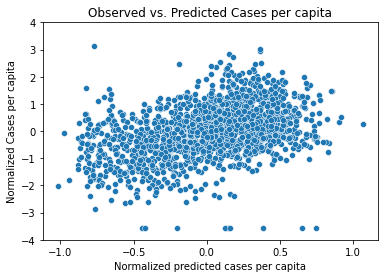

In [28]:
sns.scatterplot(x=reg.predict(X_train), y=Y_train)
plt.ylim([-4,4])
plt.title('Observed vs. Predicted Cases per capita')
plt.ylabel('Normalized Cases per capita')
plt.xlabel('Normalized predicted cases per capita');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [29]:
X2 = county_copy[['normalized mask_use_score', 'normalized avg_mobility', 'normalized percentage_vaccinated', 'normalized 9-12-21']]
Y2 = temp['normalized 9/12/21']
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state = 8)
reg2 = LinearRegression().fit(X2_train, Y2_train)
compute_CV_error(reg2, X2_train, Y2_train, 5)

0.7560758054504344

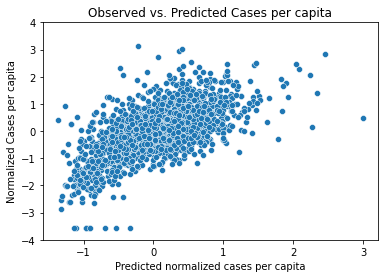

In [30]:
sns.scatterplot(x=reg2.predict(X2_train), y=Y2_train)
plt.ylim([-4,4])
plt.title('Observed vs. Predicted Cases per capita')
plt.ylabel('Normalized Cases per capita')
plt.xlabel('Predicted normalized cases per capita');

In [31]:
y2_predict = reg2.predict(X2_train)
corr2, _ = pearsonr(y2_predict, Y2_train)
corr2

0.6317143553330716

In [32]:
reg2.coef_

array([-0.2245035 , -0.00588399, -0.03491332,  0.51782334])

_We chose to add a 'death' feature to help better model the relationship between mask use, mobility, vaccination, and cases. While we may not be certain how mobility is related to cases, we know that mask use and vaccinations should reduce the number of cases. However, our original model from part a says that mask use and vaccination are positively correlated with the number of cases, since as time goes on and COVID worsens, more people wear masks and get vaccines. Introducing the death feature allows death to serve as an upper bound, helping cancel the effect of the progression of the disease to focus on the effect of the other features. Death also helps improve the model, decreasing our five-fold cross-validation error and increasing the correlation between our predictions and the observed data._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

In [87]:
reg2.intercept_

0.010692667730120096

$f(mask\_use, avg\_mobility, percent\_vaccinated, deaths) = -0.2245*mask\_use-0.0059*avg\_mobility-0.0349*percent\_vaccinated+0.5178*deaths+0.0107$

_This is the equation we get for the prediction function. This matches our physical intuition, as mask use and vaccinations are both negatively correlated with cases. We also know both deaths and cases increase over time, so their positive correlation also makes sense._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

In [ ]:
...

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [36]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [43]:
# Save your notebook first, then run this cell to export your submission.
grader.export()